#Credit Card Fraud Detection

Importing the Dependencies

In [ ]:
!pip install -q ivy
!pip install -q xgboost ipytest pandas matplotlib scikit-learn torch cryptography

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import ivy; ivy.set_backend("jax")
import jax; jax.config.update("jax_enable_x64", True)

import ivy.functional.frontends.xgboost as xgb_frontend
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from timeit import timeit
import xgboost as xgb
import pandas as pd
import functools
from tqdm import tqdm_notebook as tqdm

In [ ]:
# loading the dataset to a Pandas DataFrame
credit_card_data = pd.read_csv('creditcard.csv')

In [ ]:
# first 5 rows of the dataset
credit_card_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [ ]:
credit_card_data.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
13949,24754,1.252924,-0.182189,-0.802716,-0.210981,1.916713,3.643624,-0.778711,0.818295,1.706962,...,-0.497088,-1.211285,0.043809,0.964159,0.442030,0.261483,-0.051402,0.005112,23.74,0.0
13950,24756,-0.346979,-2.103284,-0.685061,1.961605,-0.401125,0.473632,1.133816,-0.256528,0.893409,...,0.359662,-0.316275,-0.864259,-0.279881,0.491802,-0.353996,-0.149931,0.129795,794.20,0.0
13951,24759,-6.053652,-5.988723,0.810413,-0.011811,1.308135,-0.590803,-0.725838,-0.234840,1.624646,...,-0.771970,1.474668,3.176363,-0.302410,0.052529,-0.373871,-0.700463,2.508443,60.00,0.0
13952,24759,1.169121,-1.284945,0.032717,-0.681670,0.660598,4.412578,-1.913115,1.076592,1.501230,...,-0.557596,-0.882435,-0.041523,0.975445,0.297229,0.550515,0.015029,0.032067,90.00,0.0
13953,24759,-6.917152,5.854171,-1.652458,-1.488884,-0.833891,-0.344418,0.393789,0.379968,6.133597,...,-1.404681,-1.124694,0.174333,-0.528234,0.990685,-0.035875,1.071374,-0.168831,NaN,NaN


In [ ]:
# dataset informations
credit_card_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13954 entries, 0 to 13953
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    13954 non-null  int64  
 1   V1      13954 non-null  float64
 2   V2      13954 non-null  float64
 3   V3      13954 non-null  float64
 4   V4      13954 non-null  float64
 5   V5      13954 non-null  float64
 6   V6      13954 non-null  float64
 7   V7      13954 non-null  float64
 8   V8      13954 non-null  float64
 9   V9      13954 non-null  float64
 10  V10     13954 non-null  float64
 11  V11     13954 non-null  float64
 12  V12     13954 non-null  float64
 13  V13     13954 non-null  float64
 14  V14     13954 non-null  float64
 15  V15     13954 non-null  float64
 16  V16     13954 non-null  float64
 17  V17     13954 non-null  float64
 18  V18     13954 non-null  float64
 19  V19     13954 non-null  float64
 20  V20     13954 non-null  float64
 21  V21     13954 non-null  float64
 22

In [ ]:
# checking the number of missing values in each column
credit_card_data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    1
Class     1
dtype: int64

In [ ]:
# distribution of legit transactions & fraudulent transactions
credit_card_data['Class'].value_counts()

0.0    13897
1.0       56
Name: Class, dtype: int64

This Dataset is highly unblanced

0 --> Normal Transaction

1 --> fraudulent transaction

In [ ]:
import ivy

In [ ]:
# separating the data for analysis
legit = credit_card_data[credit_card_data.Class == 0]
fraud = credit_card_data[credit_card_data.Class == 1]

In [ ]:
print(legit.shape)
print(fraud.shape)

(13897, 31)
(56, 31)


In [ ]:
# statistical measures of the data
legit.Amount.describe()

count    13897.000000
mean        63.773909
std        177.164503
min          0.000000
25%          5.770000
50%         15.900000
75%         52.370000
max       7712.430000
Name: Amount, dtype: float64

In [ ]:
fraud.Amount.describe()

count      56.000000
mean       90.815893
std       310.308450
min         0.000000
25%         1.000000
50%         1.000000
75%         1.025000
max      1809.680000
Name: Amount, dtype: float64

In [ ]:
# compare the values for both transactions
credit_card_data.groupby('Class').mean()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,
0.0,10111.481255,-0.217093,0.266252,0.887227,0.276789,-0.107510,0.136745,-0.131462,-0.020385,1.005460,...,0.020758,-0.068686,-0.158230,-0.034834,0.013065,0.117928,0.034349,0.009565,0.002329,63.773909
1.0,12262.107143,-4.727948,4.660436,-9.328536,6.783464,-2.890388,-2.030360,-6.578337,1.028374,-2.981468,...,0.453283,0.116896,0.048132,-0.225526,-0.452514,-0.124184,0.333325,0.793484,-0.046177,90.815893


Under-Sampling

Build a sample dataset containing similar distribution of normal transactions and Fraudulent Transactions

Number of Fraudulent Transactions --> 492

In [ ]:
legit_sample = legit.sample(n=492)

Concatenating two DataFrames

In [ ]:
new_dataset = pd.concat([legit_sample, fraud], axis=0)

In [ ]:
new_dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
1565,1227,-1.113706,-0.290950,1.117998,-0.159200,1.427171,-0.856862,0.199476,-0.340134,0.533594,...,-0.323045,-0.418547,-0.487299,-0.387544,-0.215703,0.062328,-0.181186,-0.240170,23.88,0.0
6110,6987,0.845688,-0.742317,0.691114,1.012910,-0.671550,0.712049,-0.556303,0.272224,2.228128,...,-0.162262,-0.300858,-0.190870,-0.318114,0.325577,0.510107,-0.057738,0.013402,159.38,0.0
140,87,-5.101877,1.897022,-3.458034,-1.277543,-5.517758,2.098366,3.329603,1.250966,0.271501,...,-0.871744,-0.678879,-0.555900,-0.761660,0.066611,0.767227,0.731634,-0.860310,919.60,0.0
2685,2226,1.033563,1.040948,-1.589245,1.516851,1.418628,0.000787,0.399256,0.233746,-0.373805,...,-0.076717,-0.011596,-0.033371,-0.981530,0.473202,-0.183575,0.106539,0.084266,3.03,0.0
10184,15707,1.108386,-0.954001,1.109283,-0.465392,-1.429866,0.006437,-1.214107,0.133998,0.680701,...,0.370387,1.046522,-0.118923,0.196136,0.223551,-0.095591,0.003862,0.021893,99.00,0.0


In [ ]:
new_dataset.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
11880,20451,-15.819179,8.775997,-22.804686,11.864868,-9.092361,-2.386893,-16.560368,0.948349,-6.310658,...,-2.350634,1.036362,1.136051,-1.043414,-0.108923,0.657437,2.136424,-1.411945,1.0,1.0
12070,20931,-16.367923,9.223692,-23.270631,11.844777,-9.462037,-2.450444,-16.925152,1.384208,-6.287736,...,-2.343674,1.004602,1.188212,-1.047184,-0.035573,0.664900,2.122796,-1.416741,1.0,1.0
12108,21046,-16.917468,9.669900,-23.736443,11.824990,-9.830548,-2.514829,-17.290657,1.820408,-6.264903,...,-2.336111,0.972755,1.241866,-1.051086,0.038009,0.672317,2.108471,-1.421243,1.0,1.0
12261,21419,-17.467710,10.114816,-24.202142,11.805469,-10.198046,-2.579938,-17.656788,2.256902,-6.242149,...,-2.328024,0.940830,1.296817,-1.055104,0.111792,0.679695,2.093541,-1.425491,1.0,1.0
12369,21662,-18.018561,10.558600,-24.667741,11.786180,-10.564657,-2.645681,-18.023468,2.693655,-6.219464,...,-2.319479,0.908839,1.352904,-1.059222,0.185751,0.687037,2.078081,-1.429517,1.0,1.0


In [ ]:
new_dataset['Class'].value_counts()

0.0    492
1.0     56
Name: Class, dtype: int64

In [ ]:
new_dataset.groupby('Class').mean()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,
0.0,9826.193089,-0.204513,0.186931,0.891840,0.337133,-0.100295,0.086351,-0.094935,-0.036999,1.005040,...,0.027809,-0.020852,-0.163868,-0.021538,0.003963,0.110157,0.055160,-0.035348,0.008068,72.102805
1.0,12262.107143,-4.727948,4.660436,-9.328536,6.783464,-2.890388,-2.030360,-6.578337,1.028374,-2.981468,...,0.453283,0.116896,0.048132,-0.225526,-0.452514,-0.124184,0.333325,0.793484,-0.046177,90.815893


Splitting the data into Features & Targets

In [ ]:
X = new_dataset.drop(columns='Class', axis=1)
Y = new_dataset['Class']

In [ ]:
print(X)

        Time         V1         V2         V3         V4         V5        V6  \
1565    1227  -1.113706  -0.290950   1.117998  -0.159200   1.427171 -0.856862   
6110    6987   0.845688  -0.742317   0.691114   1.012910  -0.671550  0.712049   
140       87  -5.101877   1.897022  -3.458034  -1.277543  -5.517758  2.098366   
2685    2226   1.033563   1.040948  -1.589245   1.516851   1.418628  0.000787   
10184  15707   1.108386  -0.954001   1.109283  -0.465392  -1.429866  0.006437   
...      ...        ...        ...        ...        ...        ...       ...   
11880  20451 -15.819179   8.775997 -22.804686  11.864868  -9.092361 -2.386893   
12070  20931 -16.367923   9.223692 -23.270631  11.844777  -9.462037 -2.450444   
12108  21046 -16.917468   9.669900 -23.736443  11.824990  -9.830548 -2.514829   
12261  21419 -17.467710  10.114816 -24.202142  11.805469 -10.198046 -2.579938   
12369  21662 -18.018561  10.558600 -24.667741  11.786180 -10.564657 -2.645681   

              V7        V8 

In [ ]:
print(Y)

1565     0.0
6110     0.0
140      0.0
2685     0.0
10184    0.0
        ... 
11880    1.0
12070    1.0
12108    1.0
12261    1.0
12369    1.0
Name: Class, Length: 548, dtype: float64


Split the data into Training data & Testing Data

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

In [ ]:
X_train, X_test, Y_train, Y_test = ivy.array(np.array(X_train)), ivy.array(np.array(X_test)), ivy.array(np.array(Y_train)), ivy.array(np.array(Y_test))

In [ ]:
print(X.shape, X_train.shape, X_test.shape)
Y_train.shape

(548, 30) ivy.Shape(438, 30) ivy.Shape(110, 30)


ivy.Shape(438)

## Prepare data

In [ ]:
def prepare_data(arrays):
    if isinstance(arrays, tuple):
        arrays = list(arrays)

    for i in range(len(arrays)):
        if len(arrays[i].shape) == 1:
            arrays[i] = ivy.expand_dims(arrays[i], axis=1).astype(ivy.float32)
        else:
            arrays[i] = ivy.array(arrays[i], dtype=ivy.float32)
    return arrays

In [ ]:
X_train, Y_train = prepare_data((X_train, Y_train))

In [ ]:
ivy.set_soft_device_mode(True)

# XGBoost Classifier Configuration
## Parameter Definitions
## Model Initialization
## Ivy-based XGBClassifier Compilation


In [ ]:
params = {
    "objective": "binary:logistic",
    "booster": "gblinear",
    "n_estimators": 100,
    "learning_rate": 0.1,
    "reg_lambda": 0.1,
    "reg_alpha": 0.1,
    "base_margin": None
}

xgb_cls = xgb.XGBClassifier(**params)
# ivy-based XGBClassifier should be compiled for better performance
ivy_cls = xgb_frontend.XGBClassifier(**params)
ivy_cls.compile(X_train, Y_train)

# XGBoost Model Training Time Benchmarking


In [ ]:
%%timeit -n 10
xgb_cls.fit(X_train, Y_train)

77.5 ms ± 41.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Ivy-based XGBoost Model Training Time Benchmarking


In [ ]:
%%timeit -n 10
ivy_cls.fit(X_train, Y_train)

52.3 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# XGBoost Model Prediction Time Benchmarking


In [ ]:
%timeit -n 100 xgb_cls.predict(X_test)

31 ms ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Ivy-based XGBoost Model Prediction Performance


In [ ]:
%timeit -n 100 ivy_cls.predict(X_test)

The slowest run took 9.42 times longer than the fastest. This could mean that an intermediate result is being cached.
431 µs ± 530 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Based on benchmark tests, the Ivy-based XGBoost implementation has demonstrated faster performance times compared to the standard XGBoost.


# Classification Reports
## IvyClassifier Report
## XGBClassifier Report


In [ ]:
ivy_pred = ivy_cls.predict(X_test)
xgb_pred = xgb_cls.predict(X_test)

print("IvyClassifier: \n", classification_report(Y_test, ivy_pred))
print("\nXGBClassifier: \n", classification_report(Y_test, xgb_pred))

IvyClassifier: 
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        99
         1.0       1.00      0.82      0.90        11

    accuracy                           0.98       110
   macro avg       0.99      0.91      0.95       110
weighted avg       0.98      0.98      0.98       110


XGBClassifier: 
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.99        99
         1.0       1.00      0.73      0.84        11

    accuracy                           0.97       110
   macro avg       0.99      0.86      0.91       110
weighted avg       0.97      0.97      0.97       110



In [ ]:
ivy_report  = classification_report(Y_test, ivy_pred, output_dict = True)
xgb_report = classification_report(Y_test, xgb_pred, output_dict = True)

# Classification Report Visualization

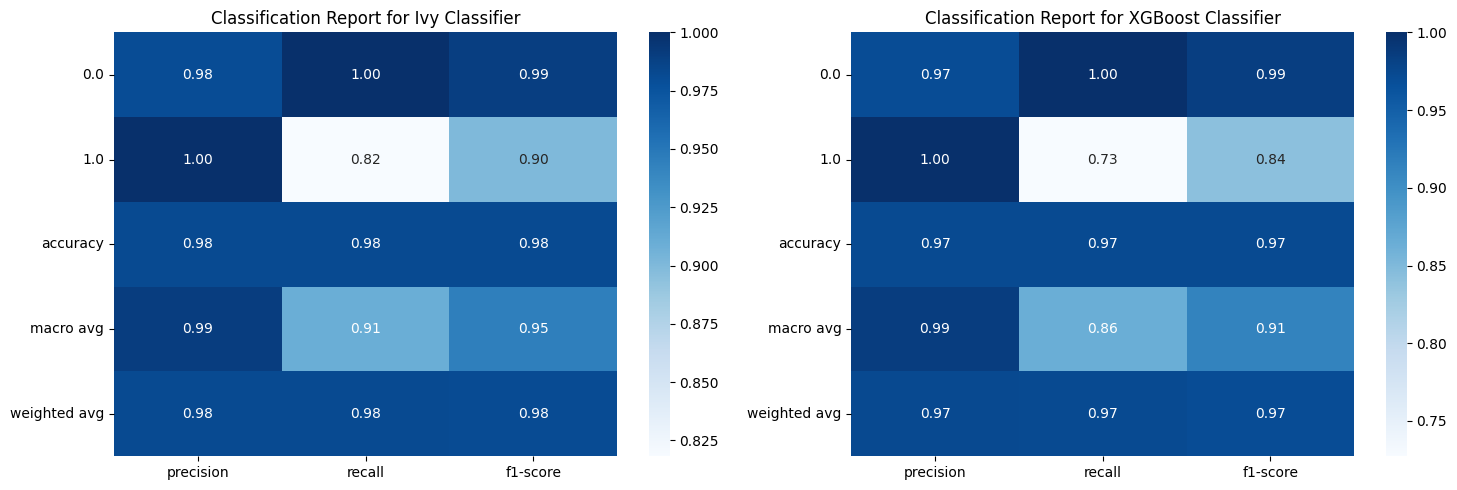

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_classification_report(report, model_name, ax):
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, fmt='.2f', cmap='Blues', ax=ax)
    ax.set_title(f'Classification Report for {model_name}')

# Create a figure for the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot the classification reports
plot_classification_report(ivy_report, 'Ivy Classifier', ax1)
plot_classification_report(xgb_report, 'XGBoost Classifier', ax2)

# Show the plots
plt.tight_layout()
plt.show()

## Based on the classification report visualizations, the Ivy-based classifier has shown better metrics compared to the standard XGBoost classifier in this evaluation.
